In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.1 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer

In [4]:
data = pd.read_csv("reddit.csv")

In [5]:
data = data.dropna()

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
tokens = []
for text in data["Generation"]:
  tokens.append(tokenizer.tokenize(text))

In [8]:
token_ids = []
for token in tokens:
  token_ids.append(tokenizer.convert_tokens_to_ids(token))

In [9]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Tokenize the text into words and sentences
feature = []
for corpus in data["Generation"]:
  words = word_tokenize(corpus)
  sentences = sent_tokenize(corpus)
  word_lengths = [len(w) for w in words if w not in stopwords.words('english')]
  avg_word_length = sum(word_lengths) / len(word_lengths)
  avg_sentence_length = len(words) / len(sentences)
  vocab = set(words)
  vocab_size = len(vocab)
  lexical_diversity = len(words) / vocab_size
  pos_tags = nltk.pos_tag(words)
  noun_count = len([w for w, pos in pos_tags if pos.startswith('NN')])
  verb_count = len([w for w, pos in pos_tags if pos.startswith('VB')])
  adj_count = len([w for w, pos in pos_tags if pos.startswith('JJ')])
  feature.append([avg_word_length, avg_sentence_length, vocab_size, lexical_diversity, noun_count, verb_count, adj_count])

In [10]:
maxlen = 100
padded_sequences = pad_sequences(token_ids, maxlen=maxlen)

In [11]:
feat = np.array(feature)

In [12]:
padd = np.concatenate([padded_sequences, feat], axis = 1)

In [13]:
labels = pd.get_dummies(data["label"]).values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(padd, labels, test_size=0.2, random_state=42)

In [15]:
model = Sequential()
model.add(Embedding(tokenizer.vocab_size + 8, 128, input_length=maxlen + 7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(3, activation="softmax"))

In [16]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
33/33 [==============================] - 20s 263ms/step - loss: 0.9386 - accuracy: 0.5291 - val_loss: 0.6637 - val_accuracy: 0.7181
Epoch 2/10
33/33 [==============================] - 5s 164ms/step - loss: 0.5660 - accuracy: 0.7083 - val_loss: 0.5207 - val_accuracy: 0.7413
Epoch 3/10
33/33 [==============================] - 6s 188ms/step - loss: 0.4052 - accuracy: 0.8110 - val_loss: 0.5286 - val_accuracy: 0.7413
Epoch 4/10
33/33 [==============================] - 5s 157ms/step - loss: 0.2486 - accuracy: 0.9002 - val_loss: 0.5017 - val_accuracy: 0.8108
Epoch 5/10
33/33 [==============================] - 4s 136ms/step - loss: 0.0937 - accuracy: 0.9748 - val_loss: 0.7142 - val_accuracy: 0.7722
Epoch 6/10
33/33 [==============================] - 5s 144ms/step - loss: 0.0643 - accuracy: 0.9777 - val_loss: 0.6139 - val_accuracy: 0.8108
Epoch 7/10
33/33 [==============================] - 3s 92ms/step - loss: 0.0360 - accuracy: 0.9942 - val_loss: 0.6069 - val_accuracy: 0.7954
Epoch 

In [18]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

11/11 [==============================] - 1s 11ms/step


In [19]:
y_test = np.argmax(y_test, axis=1)

In [20]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       123
           1       0.95      0.96      0.95        99
           2       0.65      0.61      0.63       101

    accuracy                           0.76       323
   macro avg       0.77      0.77      0.77       323
weighted avg       0.76      0.76      0.76       323

[[89  2 32]
 [ 3 95  1]
 [36  3 62]]


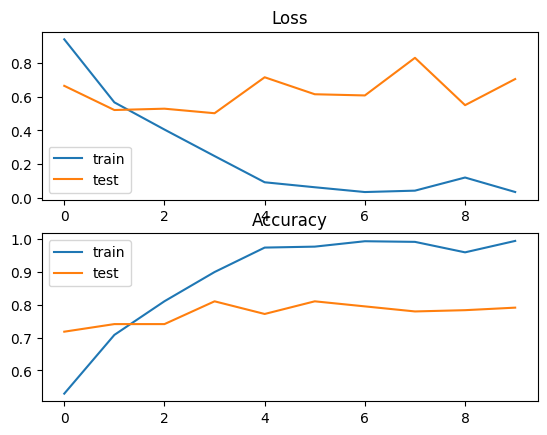

In [21]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()